<a href="https://colab.research.google.com/github/vidhigupta9/graphdatachallenge/blob/main/Exploring_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install pyTigerGraph

In [1]:
# Setup
!pip install -U pyTigerGraph
!pip install hypernetx
!pip install networkx 
!pip install sentence_transformers

## Add Imports

In [2]:
# Imports
import pyTigerGraph as tg
import json
import pandas as pd
import hypernetx as hnx
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

#preprocessing
import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
p_stemmer = PorterStemmer()

#similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#File Upload
news = pd.read_csv("newdata.csv",index_col=None)
similarity = pd.read_csv("similarity_scores.csv",index_col=None)

## Establish Initial Connection

In [4]:
# Connection parameters to Tigergraph
hostName = "https://a2c927145d9544f0968367fea409254c.i.tgcloud.io"
userName = "tigergraph"
password = "monday02"

conn = tg.TigerGraphConnection(host=hostName, username=userName, password=password)

print("Connected to",conn)

Connected to <pyTigerGraph.pyTigerGraph.TigerGraphConnection object at 0x7f84b87bb6d0>


## Publish the Graph Schema

**<h3>Note: The graph schema has been designed using the Graphstudio GUI but can be initialised with code as well.</h3>**

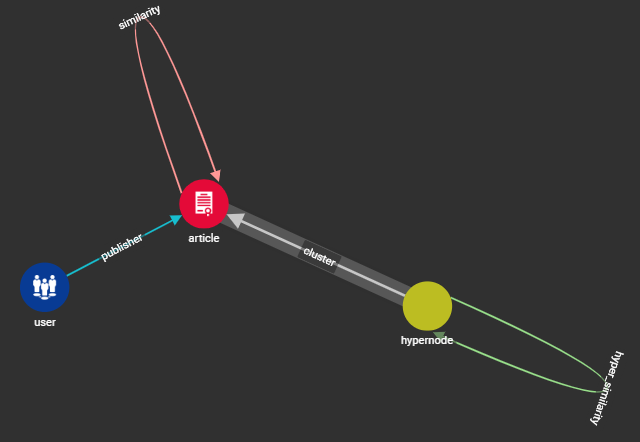

## Create the Connection

Creating connection with our schema 

In [5]:
conn.graphname="news"
secret = conn.createSecret()
authToken = conn.getToken(secret)
authToken = authToken[0]
print(authToken)
conn = tg.TigerGraphConnection(host=hostName, graphname="news", username=userName, password=password, apiToken=authToken)

def pprint(string):
  print(json.dumps(string, indent=2))

4jhi1uf4l8oil581o0mofnspdm46k06c


## Exploring the Graph

### Get Vertex and Edge Schema

In [6]:
results = conn.getVertexTypes()
print(f"Verticies: {results}")
vertices = results

results = conn.getEdgeTypes()
print(f"Edges: {results}")
edges = results

Verticies: ['article', 'user', 'hypernode']
Edges: ['publisher', 'similarity', 'hyper_similarity', 'cluster']


In [7]:
print(f"Results for Article vertex")
pprint(conn.getVertexType("article"))
print("\n-----------------\n")
print(f"Results for User vertex")
pprint(conn.getVertexType("user"))

Results for Article vertex
{
  "Config": {
    "TAGGABLE": false,
    "STATS": "OUTDEGREE_BY_EDGETYPE",
    "PRIMARY_ID_AS_ATTRIBUTE": true
  },
  "Attributes": [
    {
      "AttributeType": {
        "Name": "STRING"
      },
      "IsPartOfCompositeKey": false,
      "PrimaryIdAsAttribute": false,
      "AttributeName": "text",
      "HasIndex": false,
      "internalAttribute": false,
      "IsPrimaryKey": false
    }
  ],
  "PrimaryId": {
    "AttributeType": {
      "Name": "INT"
    },
    "IsPartOfCompositeKey": false,
    "PrimaryIdAsAttribute": true,
    "AttributeName": "id",
    "HasIndex": false,
    "internalAttribute": false,
    "IsPrimaryKey": false
  },
  "Name": "article"
}

-----------------

Results for User vertex
{
  "Config": {
    "TAGGABLE": false,
    "STATS": "OUTDEGREE_BY_EDGETYPE",
    "PRIMARY_ID_AS_ATTRIBUTE": true
  },
  "Attributes": [
    {
      "AttributeType": {
        "Name": "STRING"
      },
      "IsPartOfCompositeKey": false,
      "PrimaryId

In [8]:
print(f"Results for Publisher edge")
pprint(conn.getEdgeType("publisher"))
print("\n-----------------\n")
print(f"Results for Similarity edge")
pprint(conn.getEdgeType("similarity"))

Results for Publisher edge
{
  "IsDirected": true,
  "ToVertexTypeName": "article",
  "Config": {},
  "Attributes": [],
  "FromVertexTypeName": "user",
  "Name": "publisher"
}

-----------------

Results for Similarity edge
{
  "IsDirected": true,
  "ToVertexTypeName": "article",
  "Config": {
    "REVERSE_EDGE": "reverse_similarity"
  },
  "Attributes": [
    {
      "AttributeType": {
        "Name": "FLOAT"
      },
      "IsPartOfCompositeKey": false,
      "PrimaryIdAsAttribute": false,
      "AttributeName": "score",
      "HasIndex": false,
      "internalAttribute": false,
      "IsPrimaryKey": false
    }
  ],
  "FromVertexTypeName": "article",
  "Name": "similarity"
}


## Counting Data

In [9]:
print("Vertex Counts")
for vertex in vertices:
  print(f"There are {conn.getVertexCount(vertex)} {vertex} vertices in the graph")

Vertex Counts
There are 103 article vertices in the graph
There are 152 user vertices in the graph
There are 51 hypernode vertices in the graph


In [10]:
print("Edge Counts")
for edge in edges:
  print(f"There are {conn.getEdgeCount(edge)} {edge} edges in the graph")

Edge Counts
There are 97 publisher edges in the graph
There are 10003 similarity edges in the graph
There are 2500 hyper_similarity edges in the graph
There are 99 cluster edges in the graph


## Extracting Data

### Vertex/Edge Set Format

#### Getting a Vertex

In [11]:
results = conn.getVerticesById("article", "5")
pprint(results)

[
  {
    "v_id": "5",
    "v_type": "article",
    "attributes": {
      "id": 5,
      "text": "People Should Get Tested, Mask Mandate Be Brought Back: Doctors on Covid 19 Situation in Delhi "
    }
  }
]


#### Or Multiple Vertices

In [12]:
tdf1 = conn.getVerticesById("article", ["35","50"])
pprint(tdf1)

[
  {
    "v_id": "35",
    "v_type": "article",
    "attributes": {
      "id": 35,
      "text": "In a letter, Academy president David Rubin said that the meeting would take place on April 8 rather than April 18 following Smith's resignation."
    }
  },
  {
    "v_id": "50",
    "v_type": "article",
    "attributes": {
      "id": 50,
      "text": "Sharif sworn in as Pakistan's new PM after week of drama CP24 Toronto's Breaking News Pakistan's parliament votes in Shehbaz Sharif as PM after Imran Khan's ouster CBC News Pakistan parliament elects opposition leader as prime mi "
    }
  }
]


#### Count Edges Connected to a Vertex

In [13]:
results = conn.getEdgeCountFrom("article", "48")
pprint(results)

{
  "publisher": 0,
  "similarity": 97,
  "reverse_similarity": 103,
  "hyper_similarity": 0,
  "reverse_hyper_similarity": 0,
  "cluster": 0
}


#### Show all Edges Connected to a Vertex

In [14]:
results = conn.getEdges("article", "56")
pprint(results)

[
  {
    "e_type": "similarity",
    "directed": true,
    "from_id": "56",
    "from_type": "article",
    "to_id": "49",
    "to_type": "article",
    "attributes": {
      "score": 0.57749
    }
  },
  {
    "e_type": "similarity",
    "directed": true,
    "from_id": "56",
    "from_type": "article",
    "to_id": "56",
    "to_type": "article",
    "attributes": {
      "score": 1
    }
  },
  {
    "e_type": "similarity",
    "directed": true,
    "from_id": "56",
    "from_type": "article",
    "to_id": "63",
    "to_type": "article",
    "attributes": {
      "score": 0.65925
    }
  },
  {
    "e_type": "similarity",
    "directed": true,
    "from_id": "56",
    "from_type": "article",
    "to_id": "61",
    "to_type": "article",
    "attributes": {
      "score": 0.51648
    }
  },
  {
    "e_type": "similarity",
    "directed": true,
    "from_id": "56",
    "from_type": "article",
    "to_id": "69",
    "to_type": "article",
    "attributes": {
      "score": 0.51814
    }

### As Pandas Dataframe

#### All Vertices of one Type

In [15]:
df1 = conn.getVertexDataframe("user")
print(df1)

                           v_id  id             name
0                            13  13  Liberal Apparel
1                            28  28          INSIDER
2                       INSIDER   0                 
3                     Netamaker   0                 
4                 ilovehumanity   0                 
..                          ...  ..              ...
147                      Forbes   0                 
148                        Time   0                 
149                   PINKVILLA   0                 
150                    Politico   0                 
151  Cyber Security News (CSN)    0                 

[152 rows x 3 columns]


#### One or More Vertex

In [16]:
df2 = conn.getVertexDataframeById("user", ["45"])
print(df2)

  v_id  id       name
0   45  45  PINKVILLA


#### Convert Vertex/Edge Set to Dataframe
We'll use the results from the 'Or Multiple Vertices' cell. 

In [17]:
df3 = conn.vertexSetToDataFrame(tdf1)
print(df3)

  v_id  id                                               text
0   35  35  In a letter, Academy president David Rubin sai...
1   50  50  Sharif sworn in as Pakistan's new PM after wee...


#### Get Edges

In [18]:
df4 = conn.getEdgesDataframe("article", "34")
print(df4)

    from_type from_id  to_type to_id    score
0     article      34  article    49  0.54196
1     article      34  article    56  0.49343
2     article      34  article    63  0.54554
3     article      34  article    61  0.42563
4     article      34  article    69  0.59954
..        ...     ...      ...   ...      ...
195   article      34  article    50  0.48436
196   article      34  article     9  0.39700
197   article      34  article    26  0.62981
198   article      34  article    28  0.74792
199   article      34  article    13  0.41473

[200 rows x 5 columns]


## Path Finding
Find paths between vertices.

Supported are:
- shortestPath - one shortest path between vertices
- allPaths - all paths within the specified edge limit

In [19]:
results = conn.shortestPath([("article", "50")], [("article", "5")])
pprint(results)

[{'type': 'article', 'id': '50'}]
[{'type': 'article', 'id': '5'}]
[
  {
    "vertices": [
      {
        "v_id": "50",
        "v_type": "article",
        "attributes": {
          "id": 50,
          "text": "Sharif sworn in as Pakistan's new PM after week of drama CP24 Toronto's Breaking News Pakistan's parliament votes in Shehbaz Sharif as PM after Imran Khan's ouster CBC News Pakistan parliament elects opposition leader as prime mi "
        }
      },
      {
        "v_id": "5",
        "v_type": "article",
        "attributes": {
          "id": 5,
          "text": "People Should Get Tested, Mask Mandate Be Brought Back: Doctors on Covid 19 Situation in Delhi "
        }
      }
    ],
    "edges": [
      {
        "e_type": "similarity",
        "from_id": "50",
        "from_type": "article",
        "to_id": "5",
        "to_type": "article",
        "directed": true,
        "attributes": {
          "score": 0.50425
        }
      },
      {
        "e_type": "similar

## Insert values


In [20]:
results = conn.gsql('''
  CREATE QUERY insert_ex(INT id, STRING text) FOR GRAPH news {
 
    INSERT INTO article VALUES ( id, text );
}
''')
print(results)

Error: Currently not using any graphs! Please use 'USE GRAPH' command to switch to a graph. Create a graph if no graph exists.


In [21]:
results = conn.gsql('''
  CREATE QUERY insert_edge(INT from_article, INT to_article, FLOAT score) FOR GRAPH news {
    
     INSERT INTO similarity VALUES (from_article article, to_article article, score);
}
''')
print(results)

Error: Currently not using any graphs! Please use 'USE GRAPH' command to switch to a graph. Create a graph if no graph exists.


**These queries are reflected back to graphstudio and can be viewed in the queries section.**

## Installing Queries

Installing the queries will take a few minutes. Hang Tight! 

In [22]:
conn.gsql('''
  USE GRAPH news
  INSTALL QUERY insert_ex
  INSTALL QUERY insert_edge
''')

"Using graph 'news'\nSemantic Check Fails: Graph news: all queries in this catalog have been installed already.\nQuery installation finished.\nSemantic Check Fails: Graph news: all queries in this catalog have been installed already.\nQuery installation finished."

In [23]:
conn.gsql('''
  USE GRAPH news
  INSTALL QUERY publisher_article
  INSTALL QUERY score
''')
print("Ready to run")

Ready to run


## Run Queries

In [24]:
# Adding new article vertex to graph
conn.runInstalledQuery("insert_ex", params={"id": 97,"text":'The Ukrainian National Guard have shared a video which shows a tank firing and shooting a Russian armored vehicle at a considerable distance.  The video shows a Ukrainian tank moving up through a war torn city before coming to a halt. It then suddenly opens fire on a stationary military vehicle located quite far away, hitting it and destroying it. The shell that was fired even travels through a partially destroyed building before hitting its target.'})

[]

In [25]:
# Adding a new edge from article 0 to 98 with similarity score 0.5 just for example
conn.runInstalledQuery("insert_edge", params={"from_article": 0,"to_article":98,"score":0.5})

[]

## Adding New Article/Tweet and checking if Duplicate Exists

In [26]:
#Function for creating similarity edges in graph between exitsing vertices and new vertex

def insert_similarity_edges(new_article_id):

  #Getting all articles
  df1 = conn.getVertexDataframe("article")
  articles = df1.sort_values(by = 'id').reset_index(drop = True)['text']
  ids = df1.sort_values(by = 'id').reset_index(drop = True)['id']

  #Loading BERT model for getting embeddings of articles for similarity check
  model = SentenceTransformer('bert-base-nli-mean-tokens')

  #Encoding all the articles
  sen_embeddings = model.encode(articles)

  #Calculating cosine similarity of new article with existing
  cos_sim = cosine_similarity(
    [sen_embeddings[new_article_id]],
    sen_embeddings[:])
  
  #Creating new edges in graph between new article vertex and existing ones. The value of edge will be the similarity score
  len = cos_sim.shape[1]
  for i in range(len):

    #Checking Duplicate; If cosine similarity is greater than 0.98, it will be considered duplicate.
    if cos_sim[0][i]>0.98:
      print("Duplicate Article Detected! The new article is similar to article id " + str(ids[i]))
      
    results = conn.runInstalledQuery("insert_edge", params={"from_article": new_article_id,"to_article":i,"score":cos_sim[0][i]})

In [27]:
#Final function to add a new article to graph and check if duplicate exists

def insert_article(new_article, new_article_id = None):
  if new_article_id == None:
    new_article_id = conn.getVertexCount('article')

  #Inserting a new article (vertex)
  results = conn.runInstalledQuery("insert_ex", params={"id": new_article_id,"text":new_article})
  print("Added article in graph")

  #Creating similarity edges in graph
  insert_similarity_edges(new_article_id)

  print("Graph updated successfully!")

In [28]:
insert_article('''Delhi today recorded 1,009 new Covid cases in the last 24 hours, 
a 60 per cent rise from yesterday. This was the maximum number of cases recorded 
in Delhi since February 10 when 1,104 infections were reported
The positivity rate has gone up to 5.7 per cent. Positivity rate is the number 
of active cases per 100 tests conducted. After a steady fall in Covid cases, 
Delhi has been seen a spurt in new infections with the positivity rate 
registering a nearly three-fold rise between April 11 and 18, according 
to the Delhi Health Department's data.''')

Added article in graph
Duplicate Article Detected! The new article is similar to article id 99
Duplicate Article Detected! The new article is similar to article id 100
Duplicate Article Detected! The new article is similar to article id 101
Duplicate Article Detected! The new article is similar to article id 102
Duplicate Article Detected! The new article is similar to article id 103
Graph updated successfully!


## Hypergraph

In [29]:
similarity.head()

,from_article,to_article,similarity_score
0,0,0,1.000000
1,0,1,0.579263
2,0,2,0.382241
3,0,3,0.507944
4,0,4,0.559253


In [30]:
def build_hypergraph(similarity):
  #Populate your hypergraph
  l = []
  for i in range(len(similarity)):
    if (similarity.similarity_score[i] >= 0.75):
      if (similarity.from_article[i]!= similarity.to_article[i]):
        l.append(['{}'.format(similarity.from_article[i]),'{}'.format(similarity.to_article[i])])

  G = nx.Graph()

  #Add nodes to Graph    
  G.add_nodes_from(sum(l, []))

  #Create edges from list of nodes
  q = [[(s[i],s[i+1]) for i in range(len(s)-1)] for s in l]

  for i in q:

      #Add edges to Graph
      G.add_edges_from(i)

  #Find all connnected components in graph and list nodes for each component
  count=1
  l=[]
  for i in nx.connected_components(G):
    l.append({'hypernode':count, 'vertex_list':tuple(list(i))})
    count +=1

  ver =[]
  for i in similarity.from_article:
    ver.append('{}'.format(i))
  ver = list(set(ver))
  ver_hy = []
  for i in range(len(l)):
    for j in l[i]['vertex_list']:
      ver_hy.append(j)
  result = [i for i in ver if i not in ver_hy]

  count = len(l)
  for i in result:
    count +=1
    l.append({'hypernode':count, 'vertex_list':('{}'.format(i),)})

  res = {sub['hypernode'] : sub['vertex_list'] for sub in l}
  hy = hnx.Hypergraph(res)
  return hy,l

In [31]:
hyperg,l = build_hypergraph(similarity)

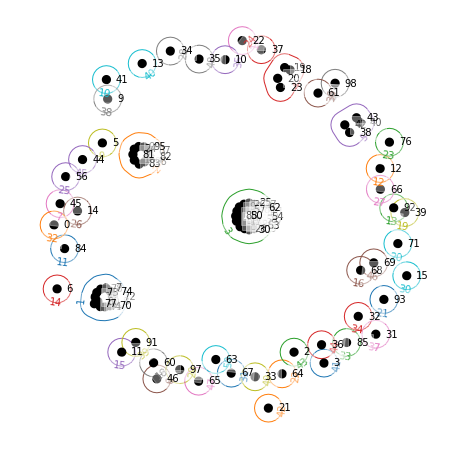

In [32]:
hnx.draw(hyperg)

In [33]:
x =[]
y= []
for i in range(len(l)):
  for j in list(l[i]['vertex_list']):
    x.append(j)
    y.append(l[i]['hypernode'])
article_hypernode = pd.DataFrame(columns={'hypernode','article'})
article_hypernode['hypernode'] = y
article_hypernode['article'] = x

In [34]:
article_hypernode.to_csv('article_hypernode.csv')

In [35]:
#normalizing text for each hypernode
def nltk_process(text):
    #Tokenization
    nltk_tokenList = word_tokenize(text)
    
    #Stemming
    nltk_stemedList = []
    for word in nltk_tokenList:
        nltk_stemedList.append(p_stemmer.stem(word))
    
    #Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    nltk_lemmaList = []
    for word in nltk_stemedList:
        nltk_lemmaList.append(wordnet_lemmatizer.lemmatize(word))
    
    #Filter stopword
    filtered_sentence = []  
    nltk_stop_words = set(stopwords.words("english"))
    for w in nltk_lemmaList:  
        if w not in nltk_stop_words:  
            filtered_sentence.append(w)
    #Removing Punctuation
    punctuations="?:!.,;"
    for word in filtered_sentence:
        if word in punctuations:
            filtered_sentence.remove(word)
    return filtered_sentence

In [36]:
data = pd.DataFrame(l,columns=['hypernode','vertex_list','normalized_text'])
news['news'] = news['news'].apply(str)
news['news'] = news['news'].apply(nltk_process)

for i in range(len(data.vertex_list)):
  a = list(data.vertex_list[i])
  emp = []
  for j in a:
    emp.append(news.iloc[int(j)].news)
  data.normalized_text[i] = emp 

In [37]:
data['normalized_text'] = data['normalized_text'].apply(list)

In [38]:
data.to_csv('hypernode.csv')

In [39]:
hypernode_df = pd.read_csv('hypernode.csv',index_col=0)

In [40]:
#hypernode vertex similarity
def similarity(df):
    sen = df.iloc[:,2]
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    sen_embeddings = model.encode(sen)
    sen_embeddings.shape
    similarity_df = pd.DataFrame(columns = ['from_article','to_article','similarity_score'])
    cos_sim = cosine_similarity(sen_embeddings,sen_embeddings)
    len = df.shape[0]
    for i in range(len):
        for j in range(len):
            similarity_df = similarity_df.append({'from_article':i,'to_article':j,'similarity_score':cos_sim[i][j]},ignore_index=True)

    similarity_df['from_article'] = similarity_df['from_article'].astype('int32')
    similarity_df['to_article'] = similarity_df['to_article'].astype('int32')
    similarity_df.to_csv('hyper_similarity.csv',index = False)

In [41]:
similarity(hypernode_df)

In [42]:
hyper_similarity = pd.read_csv('hyper_similarity.csv',index_col=None)

In [43]:
hyper_similarity.head()

,from_article,to_article,similarity_score
0,0,0,1.000000
1,0,1,0.764627
2,0,2,0.731002
3,0,3,0.665894
4,0,4,0.676944


In [44]:
hyper_similarity.to_csv("hyper_similarity.csv")

## Clear the Whole Graph
We don't want to do that yet

In [45]:
## conn.gsql('''
## USE GLOBAL
## DROP ALL
## ''')